In [1]:
import geopandas as gpd
import plotly.express as px
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [2]:
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 600
png_renderer.height = 400

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
data_dir = Path('/Users/suzinyou/Dropbox/가천대 서울연구원 프로젝트/10. 데이터산출물')

# 1. 서울

In [109]:
unit = 'hh'

In [110]:
ds = pd.read_csv(data_dir / '01_descriptive_statistics' / f'seoul_{unit + "_" if unit!="indi" else ""}desc_stat_yearonly.csv')

In [92]:
ds.head()

STD_YYYY       var    count    nmiss          mean           max  min  \
0      2002  inc_wage        0  4097264           NaN           NaN  NaN   
1      2003  inc_wage  2230794  1752582  2.930720e+07  4.713851e+10  1.0   
2      2004  inc_wage  1927949  1907044  3.317570e+07  5.704411e+10  1.0   
3      2005  inc_wage  1972263  1941762  3.515477e+07  6.014819e+10  1.0   
4      2006  inc_wage  2056317  1958360  3.686692e+07  8.001884e+10  1.0   

            std  
0           NaN  
1  5.275616e+07  
2  7.075606e+07  
3  7.872371e+07  
4  8.588905e+07

In [93]:
ds.loc[:, 'missing_frac'] = ds['nmiss'] / (ds['count'] + ds['nmiss'])

## 변수별 fraction of missing values

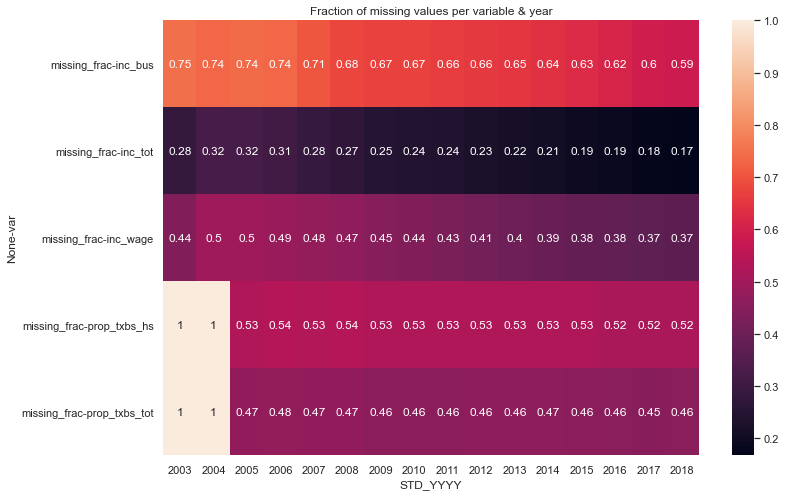

In [94]:
missing_matrix = ds.loc[
    ds['STD_YYYY'] > 2002, 
    ['var', 'STD_YYYY', 'missing_frac']
].pivot(index='STD_YYYY', columns='var').T
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Fraction of missing values per variable & year")
sns.heatmap(missing_matrix, annot=True, ax=ax);

## 평균 소득 및 과세표준 추이

In [107]:
stat2ko = {
'mean': '평균',
    'max': '최대', 'min': '최소', 'std': '표준편차', 'count':''
}

var2ko = {'inc_tot': '총소득', 'inc_wage':'근로소득', 'inc_bus':'사업소득', 'prop_txbs_tot':'총재산과세표준',}
unit2ko = {'indi': '개인', 'hh': '가구', 'eq': '균등화'}

In [99]:
pio.renderers.default = "png"
def plot_lines(variables, unit, y, title, scale=False):
    mask = ds['var'].apply(lambda x: x in variables)
    _ds = ds[mask].copy()
    if scale:
        _ds[y] /= ds.loc[mask, 'cpi']
        
    fig = px.line(_ds, x='STD_YYYY', y=y, color='var', line_dash='var')
    fig.update_traces(line=dict(width=2.4))
    fig.update_layout(
        margin={"r":16,"t":72,"l":16,"b":16},
        title=f"서울시 {unit2ko[unit]} {stat2ko[y]} {'실질' if scale else '명목'}{title} 추이 ",
        height=400, width=600)
    fig.show()

In [7]:
pop = pd.read_csv(Path('/Users/suzinyou/workspace/inequality/data/external/seoul_population_2003-2018.tsv'), sep='\t', header=2)

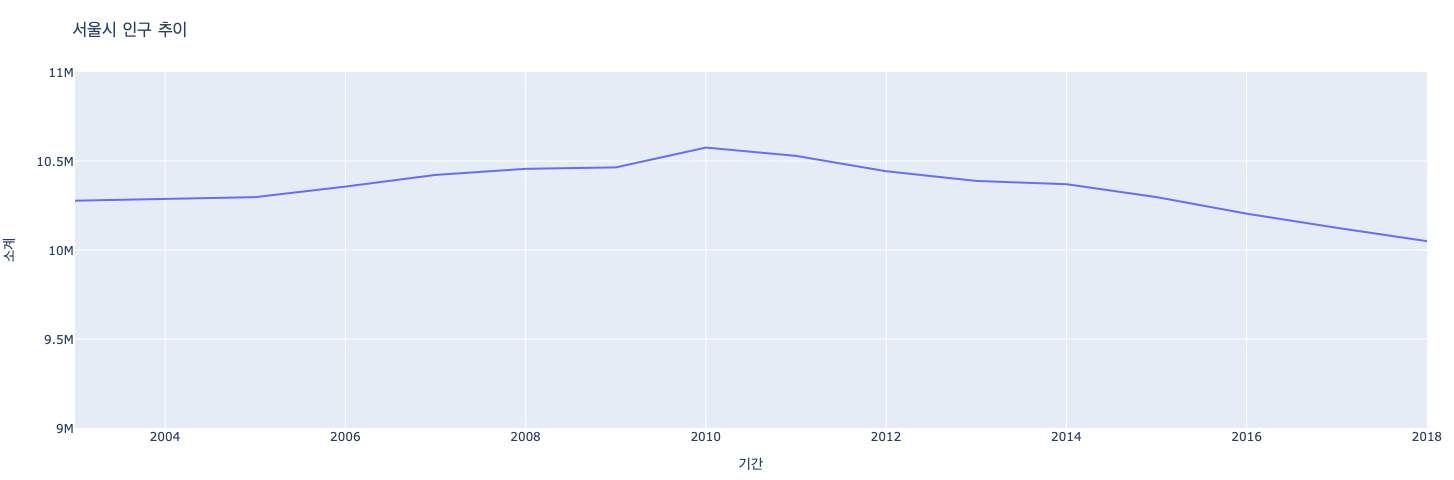

In [9]:
fig = px.line(pop, x='기간', y='소계')
fig.update_layout(
    margin={"r":16,"t":72,"l":16,"b":16},
    title=f"서울시 인구 추이",
    height=480,width=600,
    yaxis=dict(range=[9*1e6,11*1e6])
)
fig.show()

In [80]:
cpi = pd.read_excel(data_dir / 'external' / '소비자물가지수_서울과 전국__20201113113326.xlsx', index_col='시도별(2)').T.iloc[2:]
cpi /= 100
cpi = cpi.reset_index().rename(columns={'index': 'std_yyyy', '소계': '전국', '서울특별시': '서울'}).astype({'std_yyyy':int, '전국': float, '서울': float})

In [42]:
cpi.head()

시도별(2)  std_yyyy       전국       서울
0           1975  0.09986  0.09953
1           1976  0.11517  0.11490
2           1977  0.12680  0.12668
3           1978  0.14513  0.14485
4           1979  0.17173  0.17104

In [111]:
ds = ds.merge(cpi[['std_yyyy', '서울']], left_on=['STD_YYYY'], right_on=['std_yyyy']).drop(columns=['std_yyyy']).rename(columns={'서울': 'cpi'})

Count missing values into total (as 0)

In [88]:
totmask = ds['var'].apply(lambda x: x in ('inc_tot', 'prop_txbs_tot'))
ds.loc[totmask, 'mean'] = ds.loc[totmask, 'mean'] * ds.loc[totmask, 'count'] / (ds.loc[totmask, 'count'] + ds.loc[totmask, 'nmiss'])

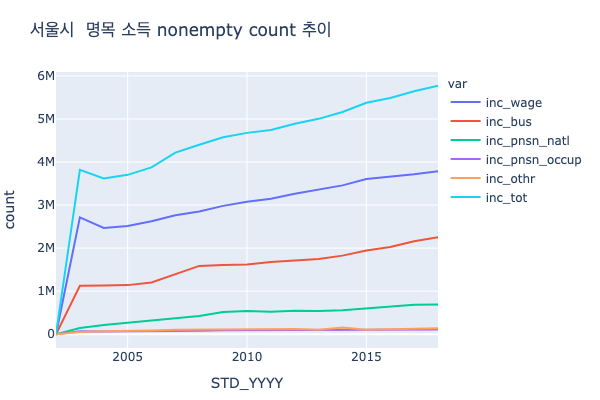

In [67]:
plot_lines(['inc_tot', 'inc_wage', 'inc_bus', 'inc_pnsn_natl', 'inc_pnsn_occup', 'inc_othr'], y='count', title='소득 nonempty count', scale=False)

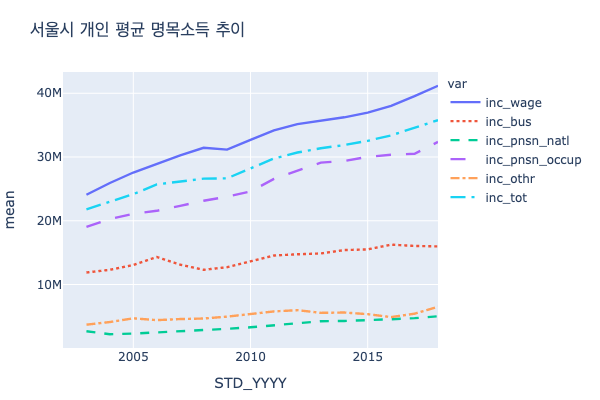

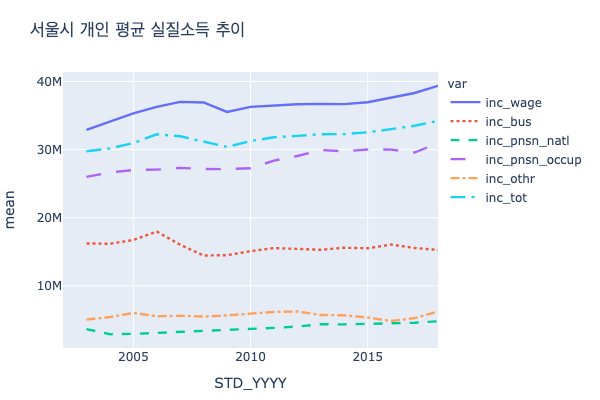

In [105]:
plot_lines(['inc_tot', 'inc_wage', 'inc_bus', 'inc_pnsn_natl', 'inc_pnsn_occup', 'inc_othr'], unit=unit, y='mean', title='소득')
plot_lines(['inc_tot', 'inc_wage', 'inc_bus', 'inc_pnsn_natl', 'inc_pnsn_occup', 'inc_othr'], unit=unit, y='mean', title='소득', scale=True)

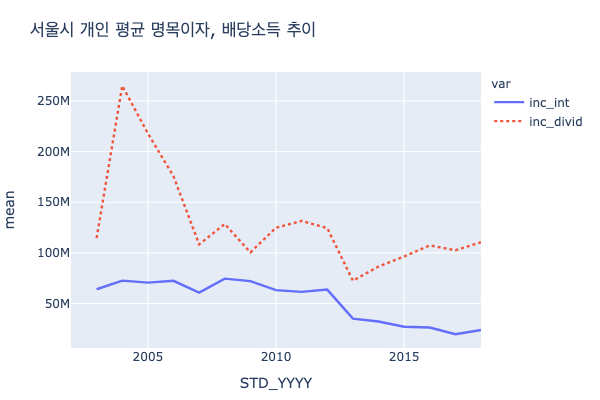

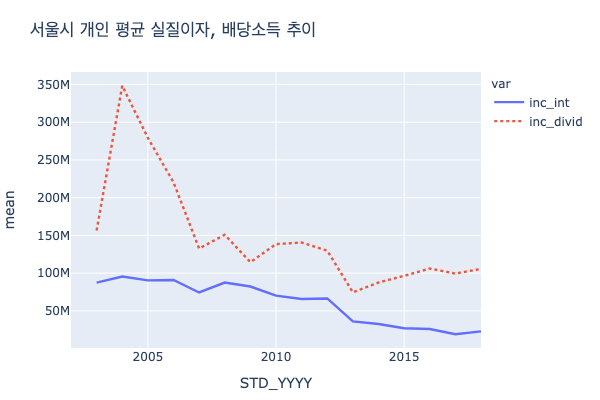

In [106]:
plot_lines(['inc_int', 'inc_divid'], unit=unit, y='mean', title='이자, 배당소득',)
plot_lines(['inc_int', 'inc_divid'], unit=unit, y='mean', title='이자, 배당소득', scale=True)

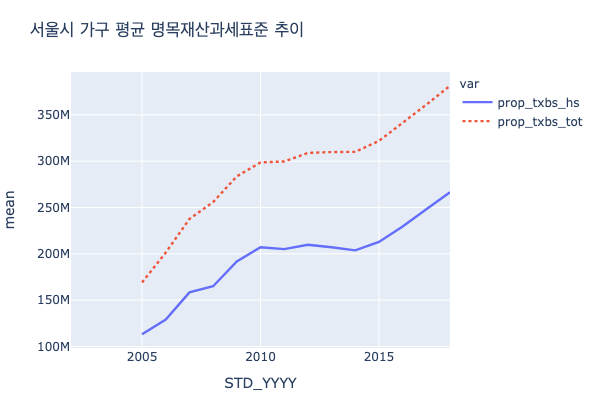

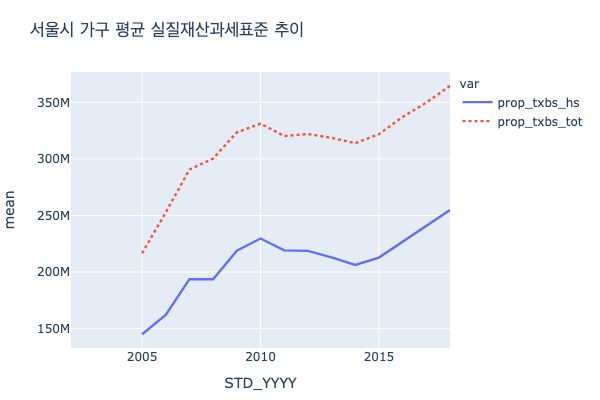

In [112]:
plot_lines([v for v in ds['var'].unique() if v.startswith('prop')], unit=unit, y='mean', title='재산과세표준',)
plot_lines([v for v in ds['var'].unique() if v.startswith('prop')], unit=unit, y='mean', title='재산과세표준', scale=True)

# 2. 서울시 25개 구별 평균 소득 추이

In [7]:
mapdir = Path(data_dir / 'external'/ 'maps')

gdf = gpd.read_file('/Users/suzinyou/Downloads/SIG/SIG.shp', encoding='utf-8')
gdf = gdf[gdf.SIG_CD.apply(lambda x: x.startswith('11'))] # 서울만 필터
gdf = gdf.to_crs(epsg=4326) # convert to GPS coordinates
gdf.to_file('geojsfile.json', driver = 'GeoJSON')
with open('geojsfile.json') as geofile:
    geojson_data = json.load(geofile)

In [114]:
sigungudf = pd.read_csv(mapdir / 'SIG.csv')

In [115]:
sigungudf.head()

SIG_CD    SIG_ENG_NM SIG_KOR_NM
0   11110     Jongno-gu        종로구
1   11140       Jung-gu         중구
2   11170    Yongsan-gu        용산구
3   11200  Seongdong-gu        성동구
4   11215   Gwangjin-gu        광진구

In [116]:
sigungudf['SIG_CD'] = sigungudf['SIG_CD'].astype(str)

In [117]:
ds = pd.read_csv(data_dir / '01_descriptive_statistics' / 'seoul_desc_stat_sidosigungu.csv')
ds.loc[:, 'SIG_CD'] = ds.apply(lambda row: str(row.sido * 1000 + row.sigungu), axis=1)
ds = ds.merge(sigungudf[['SIG_CD', 'SIG_KOR_NM', 'SIG_ENG_NM']], how='left')

In [185]:
ds.columns

Index(['STD_YYYY', 'sido', 'sigungu', 'var', 'count', 'nmiss', 'mean', 'max',
       'min', 'std', 'SIG_CD', 'SIG_KOR_NM', 'SIG_ENG_NM'],
      dtype='object')

In [118]:
ds = ds.merge(cpi[['std_yyyy', '서울']], left_on=['STD_YYYY'], right_on=['std_yyyy']).drop(columns=['std_yyyy']).rename(columns={'서울': 'cpi'})

In [120]:
ds

STD_YYYY  sido  sigungu             var  count   nmiss          mean  \
0         2002    11      110        inc_wage      0  368830           NaN   
1         2002    11      140        inc_wage      0  609270           NaN   
2         2002    11      170        inc_wage      0  314991           NaN   
3         2002    11      200        inc_wage      0  367004           NaN   
4         2002    11      215        inc_wage      0  368878           NaN   
...        ...   ...      ...             ...    ...     ...           ...   
5520      2018    11      620  prop_txbs_bldg  22027  498598  8.008273e+07   
5521      2018    11      650  prop_txbs_bldg  47886  395285  1.323993e+08   
5522      2018    11      680  prop_txbs_bldg  60902  495158  1.496822e+08   
5523      2018    11      710  prop_txbs_bldg  48315  621403  9.546640e+07   
5524      2018    11      740  prop_txbs_bldg  21970  416397  7.118393e+07   

               max     min           std SIG_CD SIG_KOR_NM    SIG_ENG_NM  \
0              NaN     NaN           NaN  11110        종로구     Jongno-gu   
1              NaN     NaN           NaN  11140         중구       Jung-gu   
2              NaN     NaN           NaN  11170        용산구    Yongsan-gu   
3              NaN     NaN           NaN  11200        성동구  Seongdong-gu   
4              NaN     NaN           NaN  11215        광진구   Gwangjin-gu   
...            ...     ...           ...    ...        ...           ...   
5520  1.097908e+10  2177.0  1.896003e+08  11620        관악구     Gwanak-gu   
5521  2.779243e+10  3431.0  4.163141e+08  11650        서초구     Seocho-gu   
5522  2.512153e+10  1148.0  4.626868e+08  11680        강남구    Gangnam-gu   
5523  1.138174e+10  2177.0  2.271659e+08  11710        송파구     Songpa-gu   
5524  4.828465e+09  2534.0  1.613103e+08  11740        강동구   Gangdong-gu   

         cpi  
0     0.7054  
1     0.7054  
2     0.7054  
3     0.7054  
4     0.7054  
...      ...  
5520  1.0458  
5521  1.0458  
5522  1.0458  
5523  1.0458  
5524  1.0458  

[5525 rows x 14 columns]

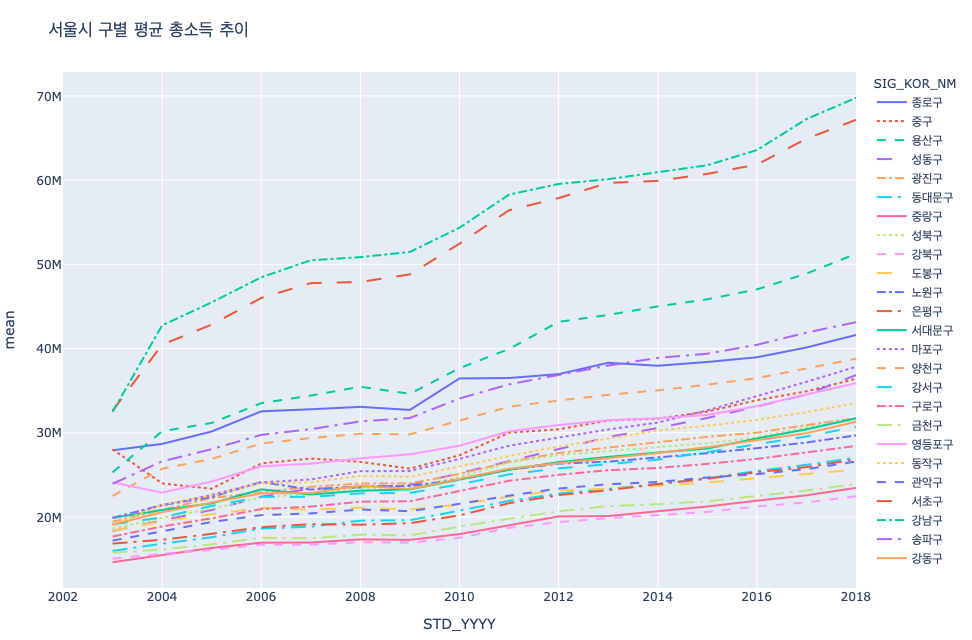

In [124]:
pio.renderers.default = 'jupyterlab'
fig = px.line(ds[ds['var']=='inc_tot'], x='STD_YYYY', y='mean', color='SIG_KOR_NM', line_dash='SIG_KOR_NM')
fig.update_layout(
    margin={"r":16,"t":72,"l":16,"b":16},
    title='서울시 구별 평균 총소득 추이',
    height=640,width=840)
fig.show()

In [ ]:
mask= ds['var']== var
_ds = ds[mask] 
_ds.loc[:, 'ds.loc[mask, 'cpi']
fig = px.line(_ds, x='STD_YYYY', y='mean', color='SIG_KOR_NM', line_dash='SIG_KOR_NM')
fig.update_layout(
    margin={"r":16,"t":72,"l":16,"b":16},
    title='서울시 구별 평균 총소득 추이',
    height=640,width=840)
fig.show()

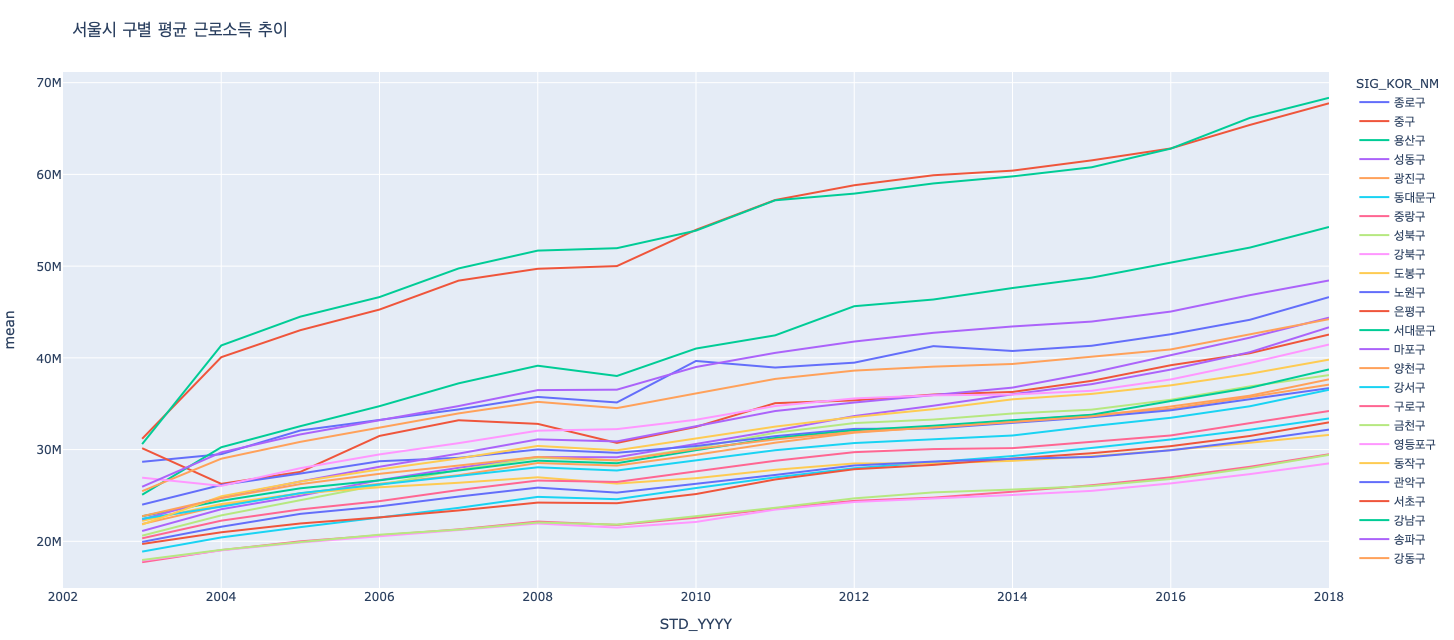

In [253]:
fig = px.line(ds[ds['var']=='inc_wage'], x='STD_YYYY', y='mean', color='SIG_KOR_NM')
fig.update_layout(
    margin={"r":16,"t":72,"l":16,"b":16},
    title='서울시 구별 평균 근로소득 추이',height=640,)
fig.show()

# 총 소득 2018

In [258]:
def show_seoul(year, var):
    df_slice = ds[(ds.STD_YYYY == year) & (ds['var'] == var)]
    fig = px.choropleth_mapbox(df_slice, 
                               geojson=geojson_data, 
                               locations='SIG_KOR_NM', 
                               color='mean',
                               color_continuous_scale="Viridis",
                               mapbox_style="carto-positron",
                               zoom=10, center = {"lat": 37.56, "lon": 126.98},
                               opacity=0.7,
                               labels={'mean':f'평균 {var2ko[var]}', 'SIG_KOR_NM':'행정구'},
                               featureidkey='properties.SIG_KOR_NM'
                              )
    fig.update_layout(margin={"r":0,"t":72,"l":0,"b":0},
                     title=f"{year}년 서울시 구별 {var2ko[var]}", height=640,)
    # TODO: dropdown menu
    fig.show()

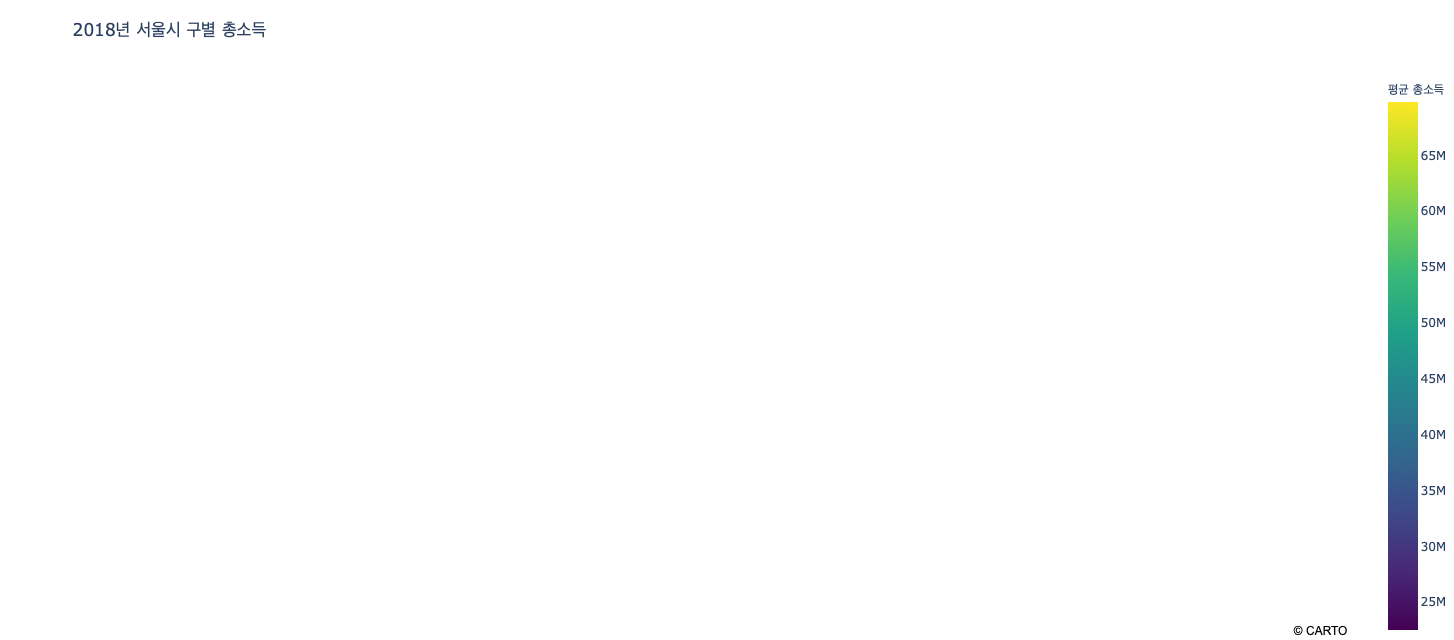

In [259]:
show_seoul(2018, 'inc_tot')

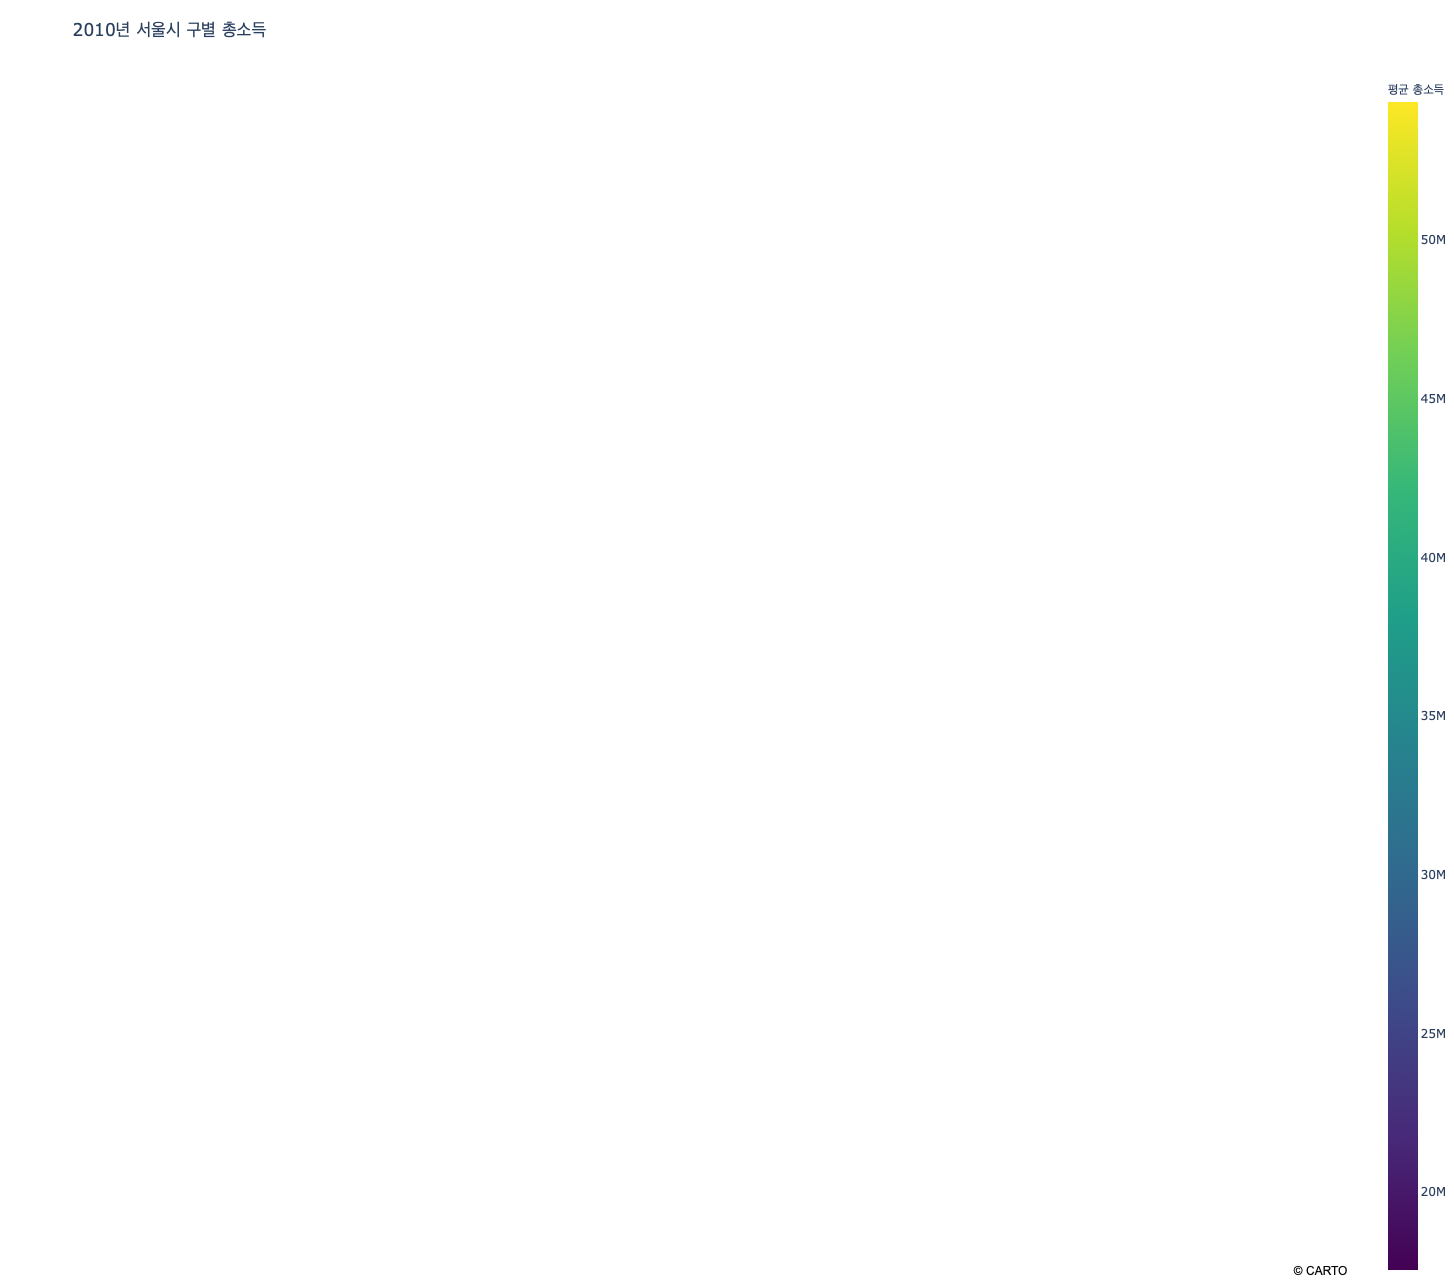

In [261]:
show_seoul(2010, 'inc_tot')

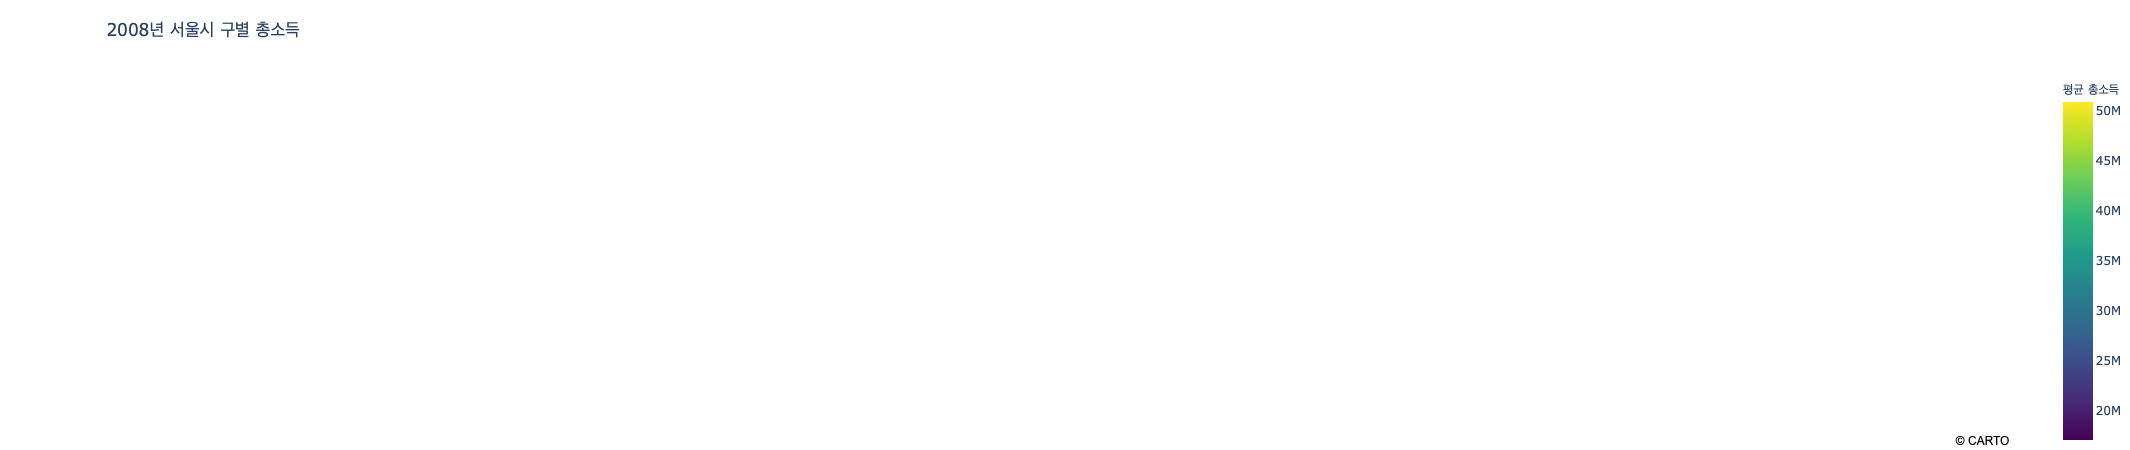

In [213]:
show_seoul(2008, 'inc_tot')

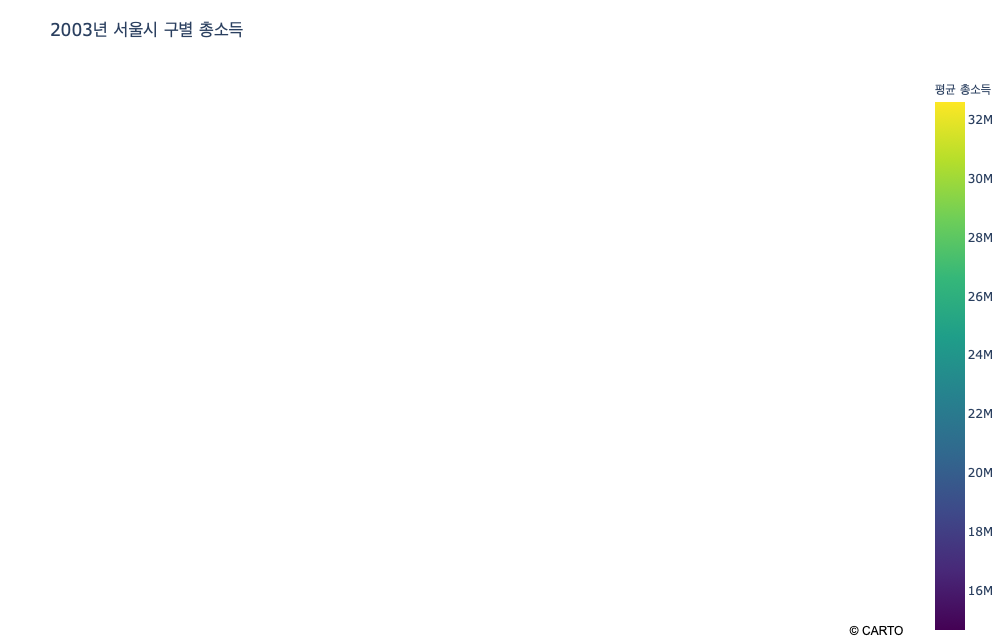

In [262]:
show_seoul(2003, 'inc_tot')

In [5]:
where_work = pd.read_csv(data_dir / '06_seoul_gu' / 'seoul_firm_sido.csv')

In [6]:
where_work.

STD_YYYY  firm_sido    count
0       2005        NaN  4944373
1       2005       11.0  4305746
2       2005       26.0    29900
3       2005       27.0    13222
4       2005       28.0   108828
..       ...        ...      ...
65      2018       45.0    32514
66      2018       46.0    40000
67      2018       47.0    53037
68      2018       48.0    53994
69      2018       50.0    16392

[70 rows x 3 columns]

In [11]:
sidodf = pd.read_csv(mapdir / 'CTPRVN.csv')

In [12]:
sidodf

CTPRVN_CD         CTP_ENG_NM CTP_KOR_NM
0          11              Seoul      서울특별시
1          26              Busan      부산광역시
2          27              Daegu      대구광역시
3          28            Incheon      인천광역시
4          29            Gwangju      광주광역시
5          30            Daejeon      대전광역시
6          31              Ulsan      울산광역시
7          36          Sejong-si    세종특별자치시
8          41        Gyeonggi-do        경기도
9          42         Gangwon-do        강원도
10         43  Chungcheongbuk-do       충청북도
11         44  Chungcheongnam-do       충청남도
12         45       Jeollabuk-do       전라북도
13         46        Jellanam-do       전라남도
14         47   Gyeongsangbuk-do       경상북도
15         48   Gyeongsangnam-do       경상남도
16         50            Jeju-do    제주특별자치도

In [15]:
where_work.merge(sidodf, how='left', left_on='firm_sido', right_on='CTPRVN_CD').to_csv(data_dir / '06_seoul_gu' / 'where_do_seoul_citizens_work.csv')